In [4]:
import pandas as pd
import os

# ✅ 연도별 파일 목록 (원본 스코어링 파일 기준)
years = ['2020', '2021', '2022', '2023', '2024']
file_template = '{}_데이터셋_스코어링.csv'  # ex: 2020_데이터셋_스코어링.csv

# ✅ Rank Scoring 대상 지표
score_columns = [
    'PER', 'PBR', 'PSR', '배당수익률',
    'ROE', 'ROA', 'EPS성장률', '영업이익률',
    '수익률', '평균거래량증가율'
]

# ✅ 결과 통합본 리스트
df_all = []

for year in years:
    file_path = file_template.format(year)

    if not os.path.exists(file_path):
        print(f"⚠️ 파일 없음: {file_path}")
        continue

    df = pd.read_csv(file_path)

    # Rank Scoring
    for col in score_columns:
        if col in df.columns:
            if col in ['PER', 'PBR', 'PSR', '배당수익률']:  # 낮을수록 좋음
                df[col + '_rank'] = df[col].rank(pct=True, ascending=True)
            else:  # 높을수록 좋음
                df[col + '_rank'] = df[col].rank(pct=True, ascending=False)

    # 연도 컬럼 추가 (통합본용)
    df['연도'] = year

    # 결과 파일로 저장
    output_file = f'{year}_데이터셋_RankScoring.csv'
    df.to_csv(output_file, index=False)
    print(f"✅ Rank Scoring 완료: {output_file}")

    # 통합본 리스트에 추가
    df_all.append(df)

# ✅ 전체 통합본 생성
if df_all:
    df_merged = pd.concat(df_all, ignore_index=True)
    merged_file = '2020_2024_데이터셋_RankScoring_통합본.csv'
    df_merged.to_csv(merged_file, index=False)
    print(f"✅ 전체 통합본 생성 완료: {merged_file}")

✅ Rank Scoring 완료: 2020_데이터셋_RankScoring.csv
✅ Rank Scoring 완료: 2021_데이터셋_RankScoring.csv
✅ Rank Scoring 완료: 2022_데이터셋_RankScoring.csv
✅ Rank Scoring 완료: 2023_데이터셋_RankScoring.csv
✅ Rank Scoring 완료: 2024_데이터셋_RankScoring.csv
✅ 전체 통합본 생성 완료: 2020_2024_데이터셋_RankScoring_통합본.csv


In [15]:
import pandas as pd

# ✅ CSV 파일 불러오기 (종목코드는 무조건 문자로 불러온다)
file_path = '/Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_RankScoring_통합본.csv'
df = pd.read_csv(file_path, dtype={'종목코드': str})

# ✅ 종목코드 6자리로 포맷 맞추기 (앞자리 0 포함)
df['종목코드'] = df['종목코드'].str.zfill(6)

# ✅ 엑셀 파일로 저장 (0 유지됨)
output_file = '/Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_RankScoring_통합본_종목코드수정.xlsx'
df.to_excel(output_file, index=False)

print(f"✅ 종목코드 앞자리 0 포함된 엑셀 파일 저장 완료: {output_file}")

✅ 종목코드 앞자리 0 포함된 엑셀 파일 저장 완료: /Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_RankScoring_통합본_종목코드수정.xlsx


In [19]:
import pandas as pd
import FinanceDataReader as fdr
from datetime import timedelta
from tqdm.auto import tqdm

# ✅ 파일 경로 (엑셀 기준)
file_path = '/Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_RankScoring_통합본_종목코드수정.xlsx'

# ✅ 데이터 불러오기
df = pd.read_excel(file_path, dtype={'종목코드': str})

# ✅ 연도별 실제 개장일 설정
reference_dates = {
    '2020': '2020-01-02',
    '2021': '2021-01-04',
    '2022': '2022-01-03',
    '2023': '2023-01-02',
    '2024': '2024-01-02'
}

# ✅ FDR 기준 종목코드 매핑 (정확성 확인)
kospi = fdr.StockListing('KOSPI')
kosdaq = fdr.StockListing('KOSDAQ')
stock_list = pd.concat([kospi, kosdaq], ignore_index=True)
stock_list['Code'] = stock_list['Code'].astype(str).str.zfill(6)

# ✅ 결과 저장 리스트
results = []

# ✅ 연도별 3개월 수익률 계산 루프 (누락 카운트 포함)
for year, ref_date_str in reference_dates.items():
    reference_date = pd.to_datetime(ref_date_str)
    target_date = reference_date + pd.DateOffset(months=3)

    codes_in_year = df[df['연도'] == int(year)]['종목코드'].astype(str).str.zfill(6).unique()

    skip_count = 0  # 누락 종목 카운트

    print(f"🔵 {year} 수익률 계산 시작 (총 {len(codes_in_year)}종목)")

    for code in tqdm(codes_in_year, desc=f"{year} Progress", leave=False):
        if code not in stock_list['Code'].values:
            skip_count += 1
            continue

        try:
            price_data = fdr.DataReader(code, start=reference_date - timedelta(days=10), end=target_date + timedelta(days=10))
            price_data = price_data.reset_index()

            t_price_data = price_data.loc[price_data['Date'] >= reference_date, 'Close']
            if t_price_data.empty:
                skip_count += 1
                continue
            t_price = t_price_data.iloc[0]

            t3m_price_data = price_data.loc[price_data['Date'] >= target_date, 'Close']
            if t3m_price_data.empty:
                skip_count += 1
                continue
            t3m_price = t3m_price_data.iloc[0]

            ret_3m = (t3m_price - t_price) / t_price

            results.append({'종목코드': code, '연도': int(year), '수익률_3개월': ret_3m})

        except:
            skip_count += 1

    print(f"✅ {year} 수익률 계산 완료 ➔ 누락된 종목: {skip_count}개\n")

# ✅ 결과 DataFrame 생성
df_target = pd.DataFrame(results)

# ✅ 종목코드 포맷 통일
df['종목코드'] = df['종목코드'].astype(str).str.zfill(6)
df_target['종목코드'] = df_target['종목코드'].astype(str).str.zfill(6)

# ✅ 병합 (X Feature + Y Target)
df_final = pd.merge(df, df_target, on=['종목코드', '연도'], how='left')

# ✅ 최종 결과 엑셀 저장
output_file = '/Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_RankScoring_with_Target.xlsx'
df_final.to_excel(output_file, index=False)

print(f"✅ 전체 데이터셋 생성 완료 ➔ {output_file}")

🔵 2020 수익률 계산 시작 (총 2477종목)


✅ 2020 수익률 계산 완료 ➔ 누락된 종목: 404개

🔵 2021 수익률 계산 시작 (총 2496종목)


✅ 2021 수익률 계산 완료 ➔ 누락된 종목: 334개

🔵 2022 수익률 계산 시작 (총 2507종목)


✅ 2022 수익률 계산 완료 ➔ 누락된 종목: 261개

🔵 2023 수익률 계산 시작 (총 2511종목)


✅ 2023 수익률 계산 완료 ➔ 누락된 종목: 194개

🔵 2024 수익률 계산 시작 (총 2521종목)


✅ 2024 수익률 계산 완료 ➔ 누락된 종목: 101개

✅ 전체 데이터셋 생성 완료 ➔ /Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_RankScoring_with_Target.xlsx


📊 3개월 수익률 기본 통계:

count    11218.000000
mean         0.017781
std          0.332603
min         -0.883848
1%          -0.490571
5%          -0.373664
25%         -0.150928
50%         -0.014654
75%          0.117135
95%          0.514762
99%          1.227266
99.5%        1.607138
max          5.691275
Name: 수익률_3개월, dtype: float64


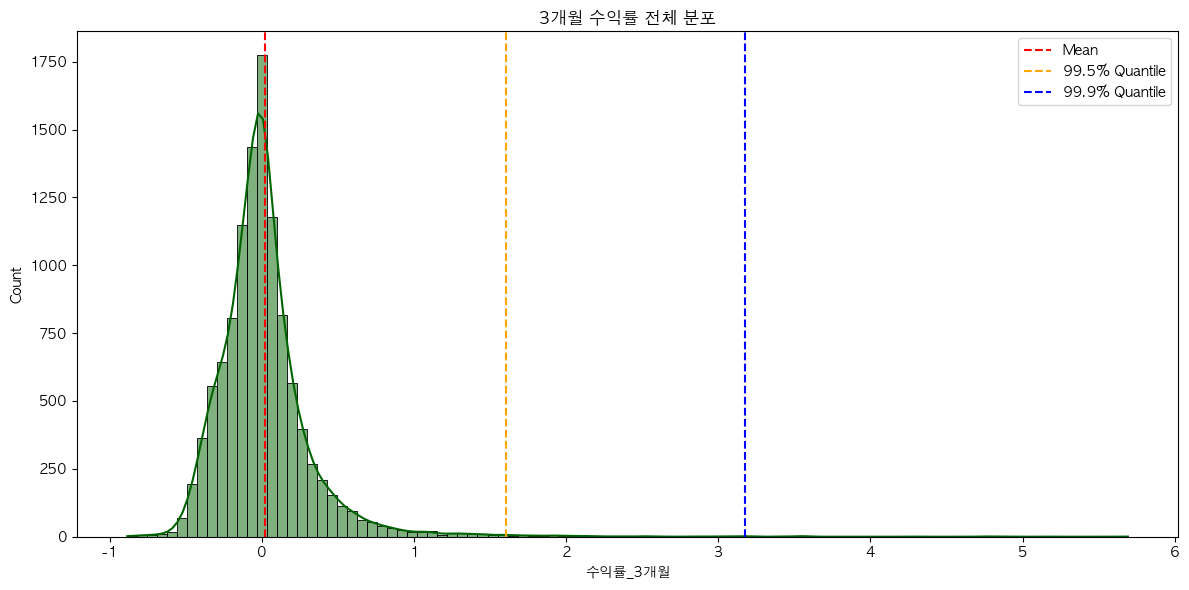

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
file_path = '/Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_RankScoring_with_Target.xlsx'
df = pd.read_excel(file_path, dtype={'종목코드': str})

# 분포 통계 요약
print("📊 3개월 수익률 기본 통계:\n")
print(df['수익률_3개월'].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99, .995]))

# 분포 시각화
plt.figure(figsize=(12,6))
sns.histplot(df['수익률_3개월'], bins=100, kde=True, color='darkgreen')
plt.title('3개월 수익률 전체 분포')
plt.axvline(df['수익률_3개월'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(df['수익률_3개월'].quantile(0.995), color='orange', linestyle='--', label='99.5% Quantile')
plt.axvline(df['수익률_3개월'].quantile(0.999), color='blue', linestyle='--', label='99.9% Quantile')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# ✅ 파일 경로 설정
file_path = '/Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_RankScoring_with_Target.xlsx'

# ✅ 데이터 불러오기
df = pd.read_excel(file_path, dtype={'종목코드': str})

# ✅ 클리핑 조건 정의
clip_settings = {
    'NoClip': None,
    'Clip_3.0': 3.0,
    'Clip_1.6': 1.6  # 99.5% 분위수 기준
}

# ✅ feature/target 컬럼 지정
feature_columns = [col for col in df.columns if col.endswith('_rank')]
target_column = '수익률_3개월'

# ✅ 결과 저장용 리스트
results = []

# ✅ 각 클리핑 조건별 모델 학습 및 평가
for clip_label, clip_value in clip_settings.items():
    df_exp = df.copy()

    # 클리핑 적용
    if clip_value is not None:
        df_exp['target'] = df_exp[target_column].clip(lower=-1, upper=clip_value)
    else:
        df_exp['target'] = df_exp[target_column]

    df_exp = df_exp.dropna(subset=feature_columns + ['target'])

    X = df_exp[feature_columns]
    y = df_exp['target']

    # 훈련/테스트 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 모델 학습 및 예측
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 성능 평가
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # 결과 저장
    results.append({'클리핑조건': clip_label, 'MAE': mae, 'R2': r2})

# ✅ 결과 출력
df_results = pd.DataFrame(results)
print("\n📊 클리핑 조건별 회귀모델 성능 비교:")
print(df_results.to_string(index=False))

# 1차 전략 수익률 실험은 Clip @ 1.6으로 집중하고,
# 필요하면 후속 비교로 No Clip / Clip 3.0을 추가


📊 클리핑 조건별 회귀모델 성능 비교:
   클리핑조건      MAE       R2
  NoClip 0.193650 0.085853
Clip_3.0 0.192365 0.089526
Clip_1.6 0.186212 0.107562


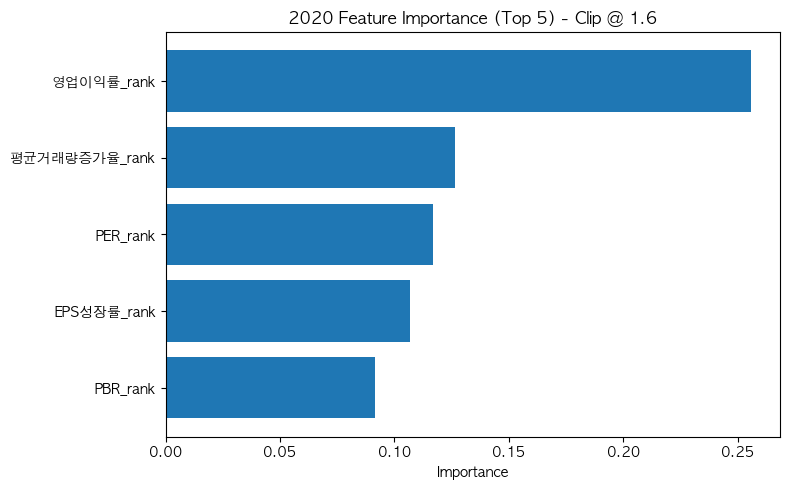

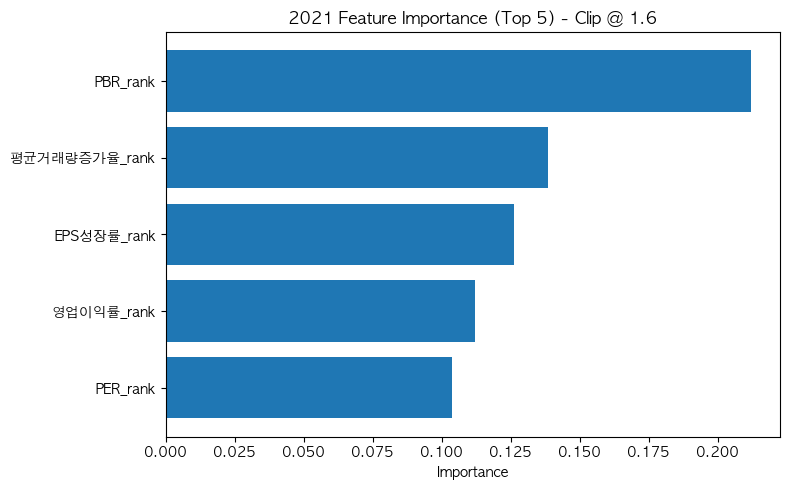

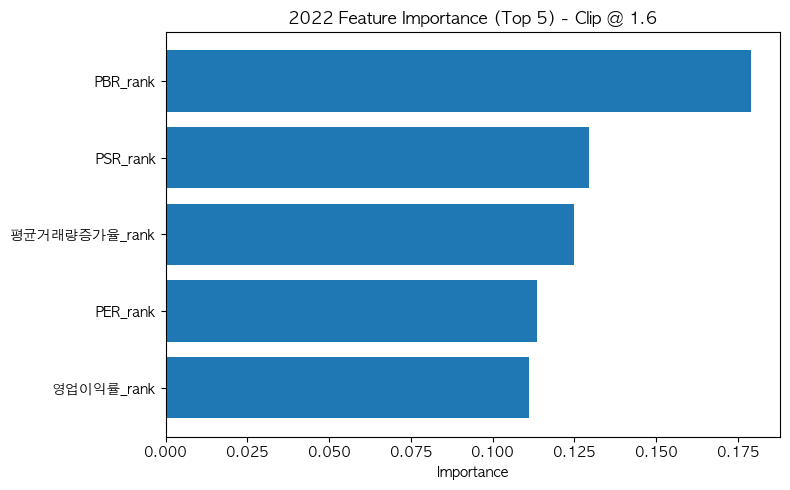

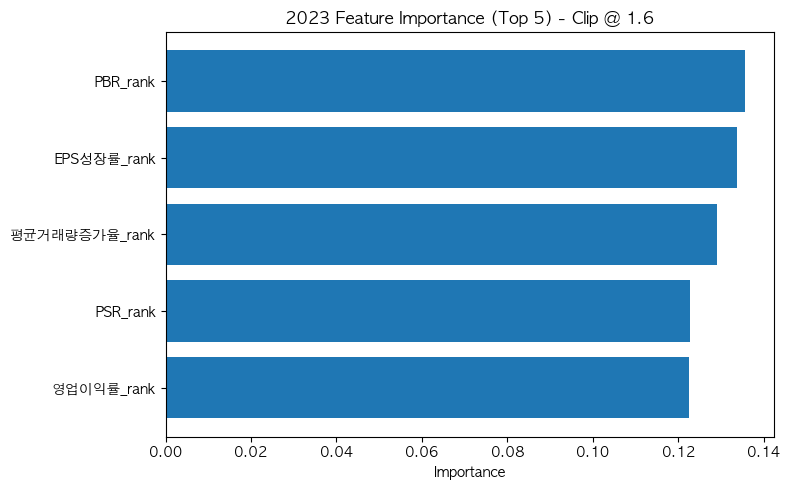

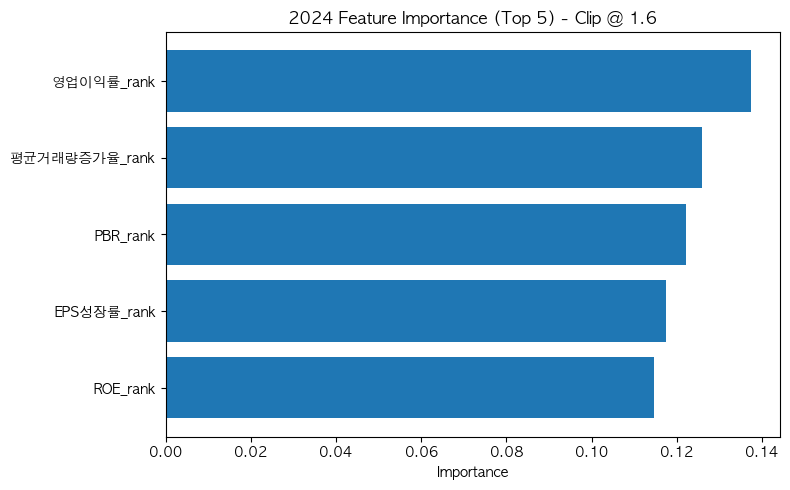

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# ✅ 데이터 로드
file_path = '/Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_RankScoring_with_Target.xlsx'
df = pd.read_excel(file_path, dtype={'종목코드': str})

# ✅ 클리핑 @ 1.6 적용
df['target'] = df['수익률_3개월'].clip(lower=-1, upper=1.6)

# ✅ Feature/Target 설정
feature_columns = [col for col in df.columns if col.endswith('_rank')]
target_column = 'target'

# ✅ 연도별 Feature Importance 계산 및 시각화
for year in sorted(df['연도'].unique()):
    df_year = df[df['연도'] == year].dropna(subset=feature_columns + [target_column])
    if len(df_year) < 50:
        continue

    X = df_year[feature_columns]
    y = df_year[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Feature Importance 추출 및 시각화
    importances = model.feature_importances_
    fi_df = pd.DataFrame({'Feature': feature_columns, 'Importance': importances})
    fi_df = fi_df.sort_values(by='Importance', ascending=False).head(5)

    plt.figure(figsize=(8,5))
    plt.barh(fi_df['Feature'][::-1], fi_df['Importance'][::-1])
    plt.title(f'{year} Feature Importance (Top 5) - Clip @ 1.6')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# ✅ 데이터 로드
file_path = '/Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_RankScoring_with_Target.xlsx'
df = pd.read_excel(file_path, dtype={'종목코드': str})

# ✅ 클리핑 @ 1.6 적용
df['target'] = df['수익률_3개월'].clip(lower=-1, upper=1.6)

# ✅ Feature 설정
feature_columns = [col for col in df.columns if col.endswith('_rank')]

# ✅ 결과 저장
top30_results = []

for year in sorted(df['연도'].unique()):
    df_year = df[df['연도'] == year].dropna(subset=feature_columns + ['수익률_3개월', 'target'])
    if len(df_year) < 50:
        continue

    X = df_year[feature_columns]
    y = df_year['target']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    df_year = df_year.copy()
    df_year['예측수익률'] = model.predict(X)

    top30 = df_year.sort_values(by='예측수익률', ascending=False).head(30)

    avg_return = top30['수익률_3개월'].mean()
    std_return = top30['수익률_3개월'].std()
    sharpe = avg_return / std_return if std_return > 0 else np.nan
    cum_return = (1 + top30['수익률_3개월']).prod() - 1

    top30_results.append({
        '연도': year,
        'Top30 평균수익률': avg_return,
        'Top30 수익률표준편차': std_return,
        'Sharpe': sharpe,
        '누적수익률': cum_return
    })

# ✅ DataFrame 변환 및 로그 누적 수익률 계산
df_top30 = pd.DataFrame(top30_results)
df_top30['log_return'] = np.log(1 + df_top30['Top30 평균수익률'])
df_top30['log_cum_return'] = df_top30['log_return'].cumsum()
df_top30['누적수익률_로그기준'] = np.exp(df_top30['log_cum_return']) - 1

# ✅ 출력
print("\n📊 Clip @ 1.6 기반 Top30 전략 수익률:")
print(df_top30[['연도', 'Top30 평균수익률', 'Sharpe', '누적수익률_로그기준']].to_string(index=False))

# 복리 계산에 따라 누적 수익률이 고수익 구조를 반영했으나, 실현 가능성보다는 예측 기반 전략의 구조적 효과를 보여주는 지표로 해석


📊 Clip @ 1.6 기반 Top30 전략 수익률:
  연도  Top30 평균수익률   Sharpe  누적수익률_로그기준
2020     1.142285 1.305600    1.142285
2021     1.539929 3.750291    4.441253
2022     0.938413 1.228496    9.547393
2023     2.362773 2.528615   34.468487
2024     1.068649 2.364309   72.371846


In [47]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# ✅ 파일 경로
file_path = '/Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_RankScoring_with_Target.xlsx'
df = pd.read_excel(file_path, dtype={'종목코드': str})

# ✅ 클리핑 @ 1.6 적용
df['target'] = df['수익률_3개월'].clip(lower=-1, upper=1.6)

# ✅ 랭크 직접 계산
df['평균거래량증가율_rank'] = df['평균거래량증가율'].rank(pct=True)
df['시가총액_rank'] = df['시가총액'].rank(pct=True)

# ✅ Feature 컬럼
feature_columns = [col for col in df.columns if col.endswith('_rank') and col != '평균거래량증가율_rank' and col != '시가총액_rank']

# ✅ 조건 필터 기준
vol_threshold = 0.8  # 평균거래량증가율_rank
cap_threshold = 0.7  # 시가총액_rank

# ✅ 결과 저장
results = []

for year in sorted(df['연도'].unique()):
    df_year = df[df['연도'] == year].dropna(subset=feature_columns + ['수익률_3개월', 'target'])
    if len(df_year) < 50:
        continue

    # 학습 데이터
    X = df_year[feature_columns]
    y = df_year['target']

    # 모델 훈련
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 예측
    df_year = df_year.copy()
    df_year['예측수익률'] = model.predict(X)

    # ✅ 조건 필터링
    filtered_df = df_year[
        (df_year['평균거래량증가율_rank'] <= vol_threshold) &
        (df_year['시가총액_rank'] <= cap_threshold)
    ]

    # ✅ 필터링된 종목 중 예측수익률 Top30
    top30 = filtered_df.sort_values(by='예측수익률', ascending=False).head(30)

    # 전략 수익률 계산
    avg_return = top30['수익률_3개월'].mean()
    std_return = top30['수익률_3개월'].std()
    sharpe = avg_return / std_return if std_return > 0 else np.nan
    cum_return = (1 + top30['수익률_3개월']).prod() - 1

    results.append({
        '연도': year,
        'Top30 평균수익률 (필터적용)': avg_return,
        'Sharpe (필터적용)': sharpe,
        '누적수익률 (필터적용)': cum_return
    })

# ✅ 누적(log) 수익률 계산
df_result = pd.DataFrame(results)
df_result['log_return'] = np.log(1 + df_result['Top30 평균수익률 (필터적용)'])
df_result['log_cum_return'] = df_result['log_return'].cumsum()
df_result['누적수익률_로그기준 (필터적용)'] = np.exp(df_result['log_cum_return']) - 1

# ✅ 결과 출력
print("\n📊 Clip @ 1.6 + 조건필터 적용 전략 수익률:")
print(df_result[['연도', 'Top30 평균수익률 (필터적용)', 'Sharpe (필터적용)', '누적수익률_로그기준 (필터적용)']].to_string(index=False))


📊 Clip @ 1.6 + 조건필터 적용 전략 수익률:
  연도  Top30 평균수익률 (필터적용)  Sharpe (필터적용)  누적수익률_로그기준 (필터적용)
2020            0.833724       0.957149           0.833724
2021            1.350051       2.675940           3.309345
2022            0.792155       1.031876           6.723016
2023            2.066342       2.033551          22.681409
2024            0.713585       2.350340          39.580115


/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  fig.canvas.draw()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


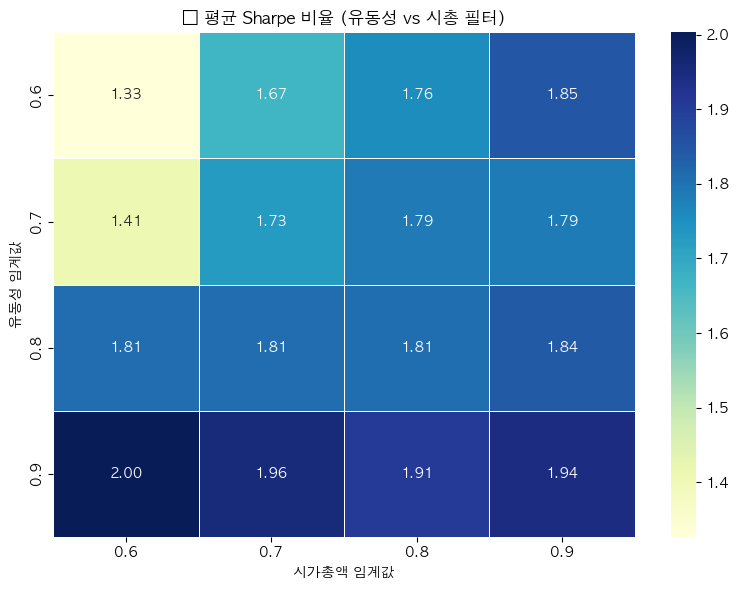


📋 조건별 평균 Sharpe 결과:
 vol_th  cap_th   Sharpe
    0.9     0.6 2.003056
    0.9     0.7 1.955027
    0.9     0.9 1.943733
    0.9     0.8 1.907275
    0.6     0.9 1.847884
    0.8     0.9 1.841218
    0.8     0.7 1.809771
    0.8     0.6 1.808322
    0.8     0.8 1.807208
    0.7     0.8 1.787225
    0.7     0.9 1.786480
    0.6     0.8 1.756875
    0.7     0.7 1.726591
    0.6     0.7 1.667190
    0.7     0.6 1.410503
    0.6     0.6 1.327032


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

# ✅ 데이터 불러오기
file_path = '/Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_RankScoring_with_Target.xlsx'
df = pd.read_excel(file_path, dtype={'종목코드': str})
df['target'] = df['수익률_3개월'].clip(lower=-1, upper=1.6)
df['평균거래량증가율_rank'] = df['평균거래량증가율'].rank(pct=True)
df['시가총액_rank'] = df['시가총액'].rank(pct=True)

# ✅ feature list
feature_columns = [col for col in df.columns if col.endswith('_rank') and col not in ['평균거래량증가율_rank', '시가총액_rank']]

# ✅ 실험 범위
vol_range = [0.6, 0.7, 0.8, 0.9]
cap_range = [0.6, 0.7, 0.8, 0.9]

# ✅ 연도 리스트
years = sorted(df['연도'].unique())

# ✅ 연도별 Sharpe 계산 함수
def compute_sharpe_for_filter(vol_th, cap_th):
    annual_sharpe = []
    for year in years:
        df_year = df[df['연도'] == year].dropna(subset=feature_columns + ['수익률_3개월', 'target'])
        if len(df_year) < 50:
            continue

        X = df_year[feature_columns]
        y = df_year['target']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        df_year = df_year.copy()
        df_year['예측수익률'] = model.predict(X)

        filtered_df = df_year[
            (df_year['평균거래량증가율_rank'] <= vol_th) &
            (df_year['시가총액_rank'] <= cap_th)
        ]

        top30 = filtered_df.sort_values(by='예측수익률', ascending=False).head(30)
        if len(top30) < 5:
            continue

        avg_return = top30['수익률_3개월'].mean()
        std_return = top30['수익률_3개월'].std()
        sharpe = avg_return / std_return if std_return > 0 else np.nan
        annual_sharpe.append(sharpe)

    mean_sharpe = np.nanmean(annual_sharpe)
    return {'vol_th': vol_th, 'cap_th': cap_th, 'Sharpe': mean_sharpe}

# ✅ 병렬 처리 실행
param_combinations = [(v, c) for v in vol_range for c in cap_range]
results = Parallel(n_jobs=-1)(delayed(compute_sharpe_for_filter)(v, c) for v, c in param_combinations)

# ✅ 결과 DataFrame 및 히트맵 시각화
df_results = pd.DataFrame(results)
pivot_table = df_results.pivot(index='vol_th', columns='cap_th', values='Sharpe')

plt.figure(figsize=(8, 6))
plt.title("📊 평균 Sharpe 비율 (유동성 vs 시총 필터)")
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.xlabel("시가총액 임계값")
plt.ylabel("유동성 임계값")
plt.tight_layout()
plt.show()

# ✅ 조건별 수치 출력
print("\n📋 조건별 평균 Sharpe 결과:")
print(df_results.sort_values(by='Sharpe', ascending=False).to_string(index=False))

# 본 전략에서는 조건 필터링 임계값을 Sharpe 비율 기준으로 정량적으로 실험하였다.  
# 유동성 기준(평균거래량증가율_rank)과 시가총액 기준(시가총액_rank)을 각각 0.6 ~ 0.9 범위에서 조합하여 평균 Sharpe 비율을 측정한 결과,  
# 유동성 ≤ 0.9, 시가총액 ≤ 0.6 조건에서 가장 높은 평균 Sharpe 비율(2.00)을 기록하였다.
# 따라서 본 프로젝트에서는 해당 값을 최적 필터 기준으로 채택하였으며, 이후 전략 고도화 및 수익률 계산에 이를 적용하였다.

In [51]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# ✅ 로컬 파일 경로 설정 (수정하지 말고 그대로 유지)
file_path = '/Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_RankScoring_with_Target.xlsx'
df = pd.read_excel(file_path, dtype={'종목코드': str})

# ✅ 클리핑 및 rank 계산
df['target'] = df['수익률_3개월'].clip(lower=-1, upper=1.6)
df['평균거래량증가율_rank'] = df['평균거래량증가율'].rank(pct=True)
df['시가총액_rank'] = df['시가총액'].rank(pct=True)

feature_columns = [col for col in df.columns if col.endswith('_rank') and col not in ['평균거래량증가율_rank', '시가총액_rank']]

# ✅ 최적 필터 기준
vol_th = 0.9
cap_th = 0.6

results = []

for year in sorted(df['연도'].unique()):
    df_year = df[df['연도'] == year].dropna(subset=feature_columns + ['수익률_3개월', 'target'])
    if len(df_year) < 50:
        continue

    X = df_year[feature_columns]
    y = df_year['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    df_year = df_year.copy()
    df_year['예측수익률'] = model.predict(X)

    filtered_df = df_year[
        (df_year['평균거래량증가율_rank'] <= vol_th) &
        (df_year['시가총액_rank'] <= cap_th)
    ]

    top30 = filtered_df.sort_values(by='예측수익률', ascending=False).head(30)
    if len(top30) < 5:
        continue

    avg_return = top30['수익률_3개월'].mean()
    std_return = top30['수익률_3개월'].std()
    sharpe = avg_return / std_return if std_return > 0 else np.nan
    cum_return = (1 + avg_return)

    results.append({
        '연도': year,
        'Top30 평균수익률 (최적필터)': avg_return,
        'Sharpe (최적필터)': sharpe,
        '단년 누적수익률': cum_return
    })

# ✅ 누적 수익률 계산
df_result = pd.DataFrame(results)
df_result['log_return'] = np.log(df_result['단년 누적수익률'])
df_result['log_cum_return'] = df_result['log_return'].cumsum()
df_result['누적수익률_로그기준 (최적필터)'] = np.exp(df_result['log_cum_return']) - 1

# ✅ 결과 출력
print("\n📊 Clip @ 1.6 + 최적 조건 필터 전략 수익률:")
print(df_result[['연도', 'Top30 평균수익률 (최적필터)', 'Sharpe (최적필터)', '누적수익률_로그기준 (최적필터)']].to_string(index=False))


📊 Clip @ 1.6 + 최적 조건 필터 전략 수익률:
  연도  Top30 평균수익률 (최적필터)  Sharpe (최적필터)  누적수익률_로그기준 (최적필터)
2020            0.948627       1.011394           0.948627
2021            1.443931       3.033770           3.762309
2022            0.645696       1.708619           6.837315
2023            2.084367       1.972425          23.173157
2024            0.626182       2.289070          38.309942


     연도  동일비중_수익률  동일비중_Sharpe  가중비중_수익률  가중비중_Sharpe    동일비중_누적    가중비중_누적
0  2020  0.948627     1.011394  1.286144     1.371243   0.948627   1.286144
1  2021  1.443931     3.033770  1.501513     3.154753   3.762309   4.718819
2  2022  0.645696     1.708619  0.781720     2.068560   6.837315   9.189334
3  2023  2.084367     1.972425  2.155943     2.040157  23.173157  31.156961
4  2024  0.626182     2.289070  0.693685     2.535835  38.309942  53.463751


/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_1932/3836560908.py:83: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) AppleGothic.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


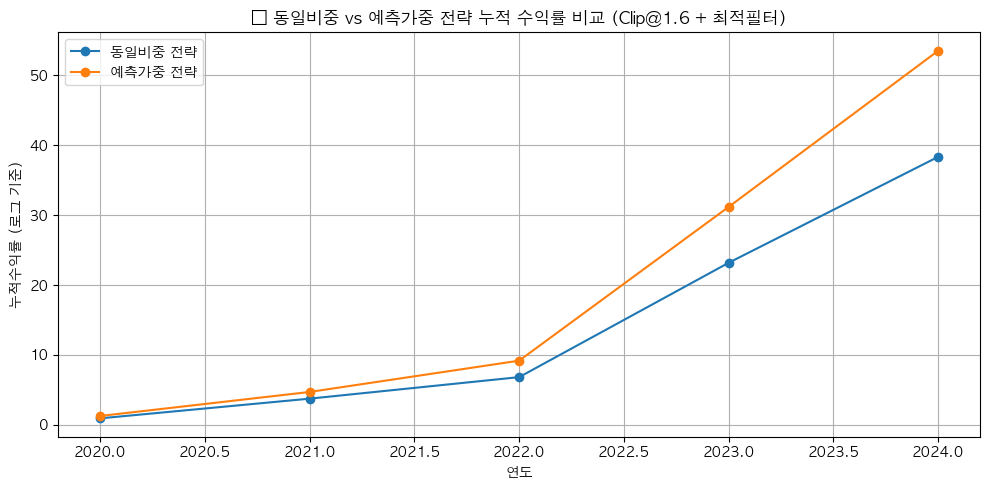

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# ✅ 로컬 파일 경로
file_path = '/Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_RankScoring_with_Target.xlsx'
df = pd.read_excel(file_path, dtype={'종목코드': str})

# ✅ 전처리
df['target'] = df['수익률_3개월'].clip(lower=-1, upper=1.6)
df['평균거래량증가율_rank'] = df['평균거래량증가율'].rank(pct=True)
df['시가총액_rank'] = df['시가총액'].rank(pct=True)

feature_columns = [col for col in df.columns if col.endswith('_rank') and col not in ['평균거래량증가율_rank', '시가총액_rank']]
vol_th, cap_th = 0.9, 0.6

# ✅ 결과 저장
result_rows = []

for year in sorted(df['연도'].unique()):
    df_year = df[df['연도'] == year].dropna(subset=feature_columns + ['수익률_3개월', 'target'])
    if len(df_year) < 50:
        continue

    X = df_year[feature_columns]
    y = df_year['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    df_year = df_year.copy()
    df_year['예측수익률'] = model.predict(X)

    filtered_df = df_year[
        (df_year['평균거래량증가율_rank'] <= vol_th) &
        (df_year['시가총액_rank'] <= cap_th)
    ]

    top30 = filtered_df.sort_values(by='예측수익률', ascending=False).head(30).copy()
    if len(top30) < 5:
        continue

    # 동일비중 전략
    avg_equal = top30['수익률_3개월'].mean()
    std_equal = top30['수익률_3개월'].std()
    sharpe_equal = avg_equal / std_equal if std_equal > 0 else np.nan

    # 가중치 전략
    top30['가중치'] = top30['예측수익률'] / top30['예측수익률'].sum()
    top30['가중수익률'] = top30['가중치'] * top30['수익률_3개월']
    avg_weighted = top30['가중수익률'].sum()
    std_weighted = top30['수익률_3개월'].std()
    sharpe_weighted = avg_weighted / std_weighted if std_weighted > 0 else np.nan

    result_rows.append({
        '연도': year,
        '동일비중_수익률': avg_equal,
        '동일비중_Sharpe': sharpe_equal,
        '가중비중_수익률': avg_weighted,
        '가중비중_Sharpe': sharpe_weighted
    })

# ✅ 누적 수익률 계산
df_result = pd.DataFrame(result_rows)
df_result['동일비중_누적'] = np.exp(np.log(1 + df_result['동일비중_수익률']).cumsum()) - 1
df_result['가중비중_누적'] = np.exp(np.log(1 + df_result['가중비중_수익률']).cumsum()) - 1

# ✅ 결과 출력
print(df_result)

# ✅ 누적 수익률 시각화
plt.figure(figsize=(10, 5))
plt.plot(df_result['연도'], df_result['동일비중_누적'], label='동일비중 전략', marker='o')
plt.plot(df_result['연도'], df_result['가중비중_누적'], label='예측가중 전략', marker='o')
plt.title('📈 동일비중 vs 예측가중 전략 누적 수익률 비교 (Clip@1.6 + 최적필터)')
plt.xlabel('연도')
plt.ylabel('누적수익률 (로그 기준)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
import FinanceDataReader as fdr

# ✅ 연도별 KOSPI 수익률 계산
kospi_returns = []
for year in sorted(df['연도'].unique()):
    start = f"{year}-01-02"
    end = pd.to_datetime(start) + pd.DateOffset(months=3)

    kospi = fdr.DataReader('KS11', start=start, end=end)
    kospi = kospi.reset_index()
    try:
        start_price = kospi.iloc[0]['Close']
        end_price = kospi.iloc[-1]['Close']
        kospi_return = (end_price - start_price) / start_price
    except:
        kospi_return = np.nan
    kospi_returns.append({'연도': year, 'KOSPI_수익률': kospi_return})

# ✅ 병합 및 초과수익률 계산
df_kospi = pd.DataFrame(kospi_returns)
df_result = pd.merge(df_result, df_kospi, on='연도', how='left')
df_result['동일비중_초과'] = df_result['동일비중_수익률'] - df_result['KOSPI_수익률']
df_result['가중비중_초과'] = df_result['가중비중_수익률'] - df_result['KOSPI_수익률']

# ✅ 초과수익률 출력
print("\n📊 동일비중 vs 가중전략의 KOSPI 초과수익률 비교:")
print(df_result[['연도', '동일비중_초과', '가중비중_초과']])


📊 동일비중 vs 가중전략의 KOSPI 초과수익률 비교:
     연도   동일비중_초과   가중비중_초과
0  2020  1.155650  1.493167
1  2021  1.386755  1.444338
2  2022  0.728981  0.865005
3  2023  1.971507  2.043083
4  2024  0.594962  0.662465


/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_1932/3746347974.py:103: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) AppleGothic.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


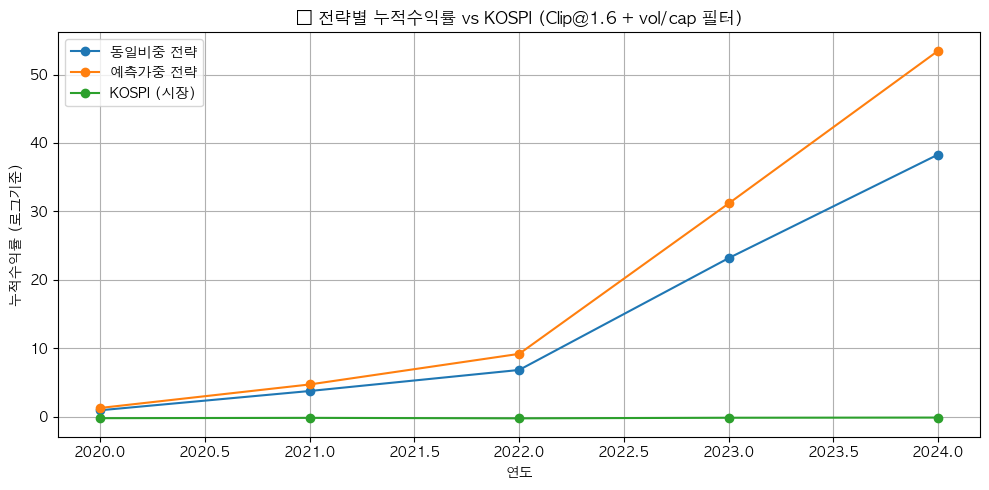


📊 전략 수익률 & 초과수익률 요약:
     연도  KOSPI_수익률  동일비중_수익률  가중비중_수익률   동일비중_초과   가중비중_초과
0  2020  -0.207023  0.948627  1.286144  1.155650  1.493167
1  2021   0.057175  1.443931  1.501513  1.386755  1.444338
2  2022  -0.083285  0.645696  0.781720  0.728981  0.865005
3  2023   0.112860  2.084367  2.155943  1.971507  2.043083
4  2024   0.031219  0.626182  0.693685  0.594962  0.662465


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import FinanceDataReader as fdr

# ✅ 1. 데이터 로드 및 기본 전처리
file_path = '/Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_RankScoring_with_Target.xlsx'
df = pd.read_excel(file_path, dtype={'종목코드': str})
df['target'] = df['수익률_3개월'].clip(lower=-1, upper=1.6)
df['평균거래량증가율_rank'] = df['평균거래량증가율'].rank(pct=True)
df['시가총액_rank'] = df['시가총액'].rank(pct=True)

feature_columns = [col for col in df.columns if col.endswith('_rank') and col not in ['평균거래량증가율_rank', '시가총액_rank']]
vol_th, cap_th = 0.9, 0.6

# ✅ 2. 전략 수익률 계산 (동일비중 vs 가중비중)
result_rows = []

for year in sorted(df['연도'].unique()):
    df_year = df[df['연도'] == year].dropna(subset=feature_columns + ['수익률_3개월', 'target'])
    if len(df_year) < 50:
        continue

    X = df_year[feature_columns]
    y = df_year['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    df_year = df_year.copy()
    df_year['예측수익률'] = model.predict(X)

    filtered_df = df_year[
        (df_year['평균거래량증가율_rank'] <= vol_th) &
        (df_year['시가총액_rank'] <= cap_th)
    ]

    top30 = filtered_df.sort_values(by='예측수익률', ascending=False).head(30).copy()
    if len(top30) < 5:
        continue

    # 동일비중 전략
    avg_equal = top30['수익률_3개월'].mean()
    std_equal = top30['수익률_3개월'].std()
    sharpe_equal = avg_equal / std_equal if std_equal > 0 else np.nan

    # 가중치 전략
    top30['가중치'] = top30['예측수익률'] / top30['예측수익률'].sum()
    top30['가중수익률'] = top30['가중치'] * top30['수익률_3개월']
    avg_weighted = top30['가중수익률'].sum()
    std_weighted = top30['수익률_3개월'].std()
    sharpe_weighted = avg_weighted / std_weighted if std_weighted > 0 else np.nan

    result_rows.append({
        '연도': year,
        '동일비중_수익률': avg_equal,
        '동일비중_Sharpe': sharpe_equal,
        '가중비중_수익률': avg_weighted,
        '가중비중_Sharpe': sharpe_weighted
    })

df_result = pd.DataFrame(result_rows)

# ✅ 3. KOSPI 수익률 가져오기
kospi_returns = []
for year in df_result['연도']:
    start = f"{year}-01-02"
    end = pd.to_datetime(start) + pd.DateOffset(months=3)
    try:
        kospi = fdr.DataReader('KS11', start=start, end=end).reset_index()
        start_price = kospi.iloc[0]['Close']
        end_price = kospi.iloc[-1]['Close']
        kospi_return = (end_price - start_price) / start_price
    except:
        kospi_return = np.nan
    kospi_returns.append({'연도': year, 'KOSPI_수익률': kospi_return})

df_kospi = pd.DataFrame(kospi_returns)
df_result = pd.merge(df_result, df_kospi, on='연도', how='left')

# ✅ 4. 초과수익률 계산
df_result['동일비중_초과'] = df_result['동일비중_수익률'] - df_result['KOSPI_수익률']
df_result['가중비중_초과'] = df_result['가중비중_수익률'] - df_result['KOSPI_수익률']

# ✅ 5. 누적수익률 계산
df_result['동일비중_누적'] = np.exp(np.log(1 + df_result['동일비중_수익률']).cumsum()) - 1
df_result['가중비중_누적'] = np.exp(np.log(1 + df_result['가중비중_수익률']).cumsum()) - 1
df_result['KOSPI_누적'] = np.exp(np.log(1 + df_result['KOSPI_수익률']).cumsum()) - 1

# ✅ 6. 시각화
plt.figure(figsize=(10, 5))
plt.plot(df_result['연도'], df_result['동일비중_누적'], marker='o', label='동일비중 전략')
plt.plot(df_result['연도'], df_result['가중비중_누적'], marker='o', label='예측가중 전략')
plt.plot(df_result['연도'], df_result['KOSPI_누적'], marker='o', label='KOSPI (시장)')
plt.title("📈 전략별 누적수익률 vs KOSPI (Clip@1.6 + vol/cap 필터)")
plt.xlabel("연도")
plt.ylabel("누적수익률 (로그기준)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ 7. 최종 결과 테이블 출력
print("\n📊 전략 수익률 & 초과수익률 요약:")
print(df_result[['연도', 'KOSPI_수익률', '동일비중_수익률', '가중비중_수익률', '동일비중_초과', '가중비중_초과']])

In [75]:
# ⬇ 기존 모델 학습 + 예측 수익률까지 끝낸 상태여야 함

top30_list = []

for year in sorted(df['연도'].unique()):
    df_year = df[df['연도'] == year].dropna(subset=feature_columns + ['target', '수익률_3개월'])
    if len(df_year) < 50:
        continue

    X = df_year[feature_columns]
    y = df_year['target']

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(*train_test_split(X, y, test_size=0.2, random_state=42)[::2])

    df_year = df_year.copy()
    df_year['예측수익률'] = model.predict(X)

    top30 = df_year.sort_values(by='예측수익률', ascending=False).head(30).copy()
    top30['연도'] = year

    top30 = top30[['연도', '종목코드', '기업명', '예측수익률', '수익률_3개월']]
    top30['가중치'] = top30['예측수익률'] / top30['예측수익률'].sum()
    top30['가중수익률'] = top30['가중치'] * top30['수익률_3개월']

    top30_list.append(top30)

# 저장
df_top30_predicted = pd.concat(top30_list, ignore_index=True)
df_top30_predicted.to_excel('/Users/gun/Desktop/경종설/예측수익률_Top30_연도별.xlsx', index=False)
print("예측 기반 Top30 종목 리스트 저장 완료: 예측수익률_Top30_연도별.xlsx")

예측 기반 Top30 종목 리스트 저장 완료: 예측수익률_Top30_연도별.xlsx


In [68]:
import pandas as pd
import time
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from joblib import Parallel, delayed
from tqdm import tqdm

# ✅ 1. 데이터 불러오기
file_path = '/Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_RankScoring_with_Target.xlsx'
df = pd.read_excel(file_path, dtype={'종목코드': str})
df['종목코드'] = df['종목코드'].str.zfill(6)

# ✅ 2. 종목코드 고유 추출
unique_codes = df['종목코드'].dropna().unique()

# ✅ 3. 크롬 드라이버 옵션
options = Options()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# ✅ 4. WICS 업종 수집 함수
def fetch_sector(code):
    try:
        driver = webdriver.Chrome(options=options)
        url = f"https://finance.naver.com/item/coinfo.naver?code={code}&target=coinfo"
        driver.get(url)
        time.sleep(2)
        driver.switch_to.frame("coinfo_cp")
        time.sleep(0.5)
        body_text = driver.find_element(By.TAG_NAME, 'body').text
        driver.quit()
        for line in body_text.split('\n'):
            if 'WICS :' in line:
                return code, line.split('WICS :')[-1].strip()
        return code, None
    except Exception as e:
        return code, None

# ✅ 5. 병렬 수집
results = Parallel(n_jobs=4)(  # CPU 너무 과부하 방지: 4개 쓰레드 제한
    delayed(fetch_sector)(code) for code in tqdm(unique_codes, desc='📡 산업군 수집 중')
)

# ✅ 6. 병합 및 저장
sector_df = pd.DataFrame(results, columns=['종목코드', '산업군'])
df_final = pd.merge(df, sector_df, on='종목코드', how='left')

# ✅ 7. 저장
save_path = '/Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_WICS포함.xlsx'
df_final.to_excel(save_path, index=False)
print(f'\n✅ 산업군 병합 완료: {save_path}')

📡 산업군 수집 중: 100%|██████████| 2521/2521 [50:46<00:00,  1.21s/it] 



✅ 산업군 병합 완료: /Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_WICS포함.xlsx


/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_1932/1038914.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


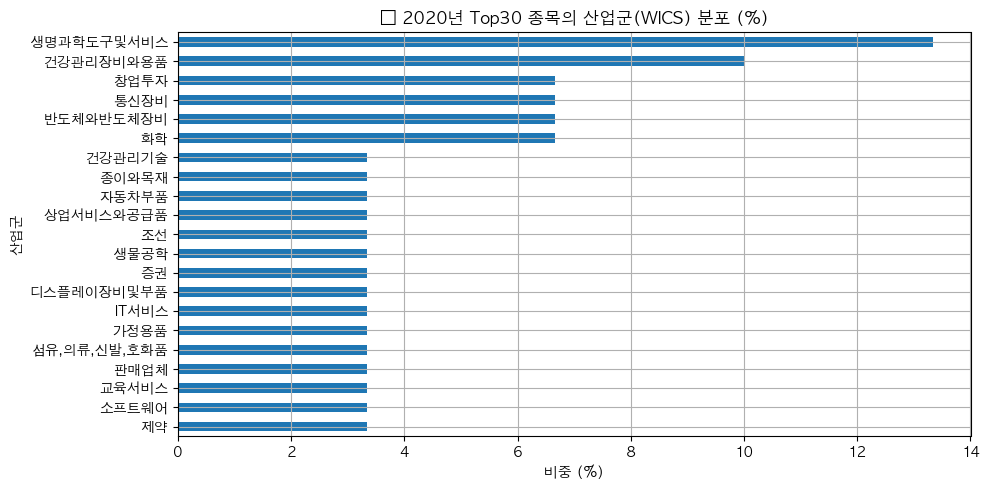

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_1932/1038914.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


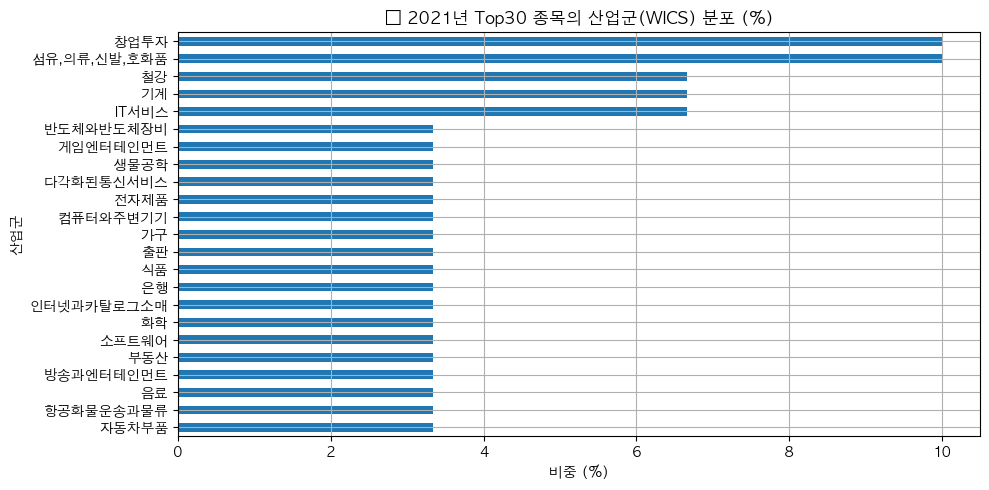

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_1932/1038914.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


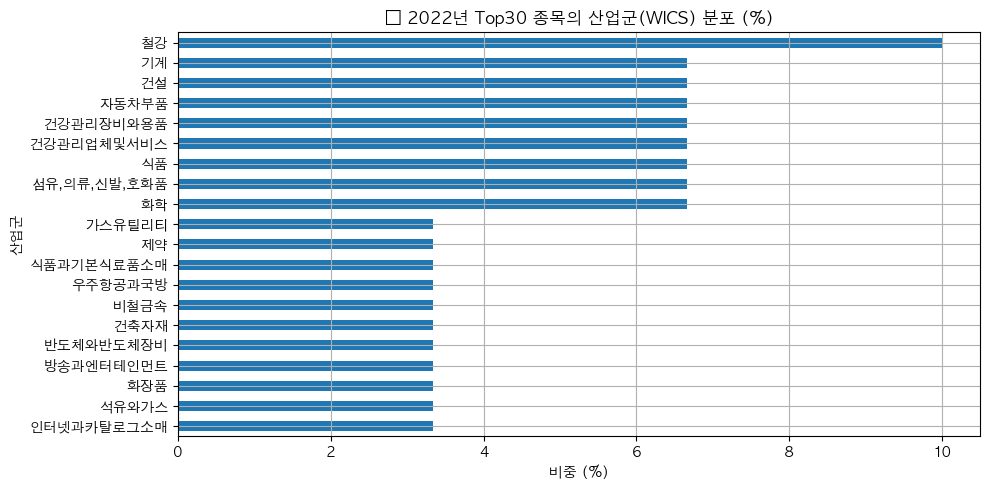

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_1932/1038914.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


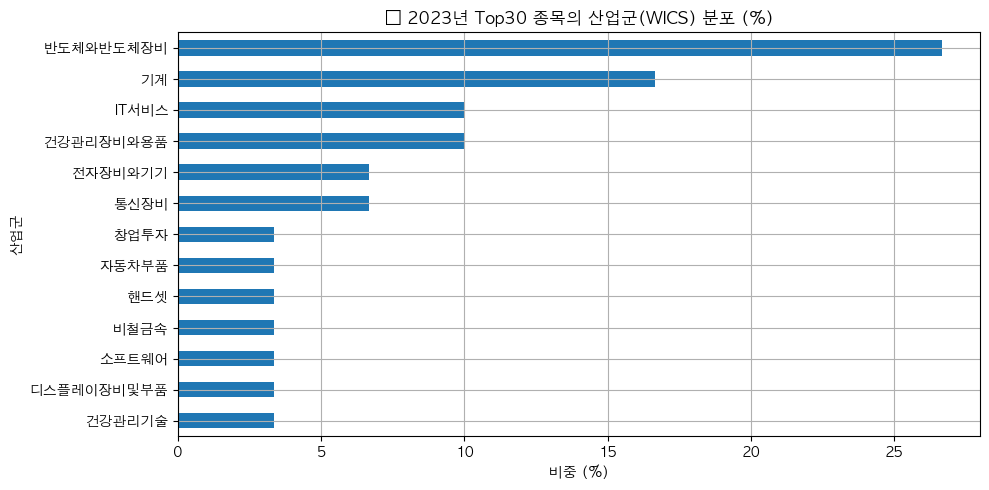

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_1932/1038914.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


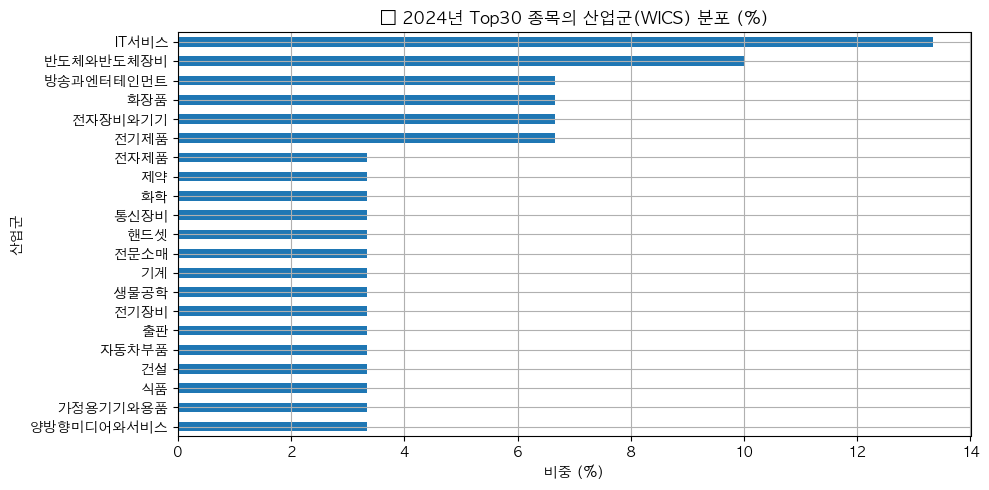

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# ✅ 파일 경로 (로컬 실행)
file_path = '/Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_WICS포함.xlsx'
df = pd.read_excel(file_path, dtype={'종목코드': str})

# ✅ 산업군 컬럼 확인
if '산업군' not in df.columns:
    raise ValueError("❌ '산업군' 컬럼이 포함된 파일이 필요합니다.")

# ✅ 기본 전처리
df['target'] = df['수익률_3개월'].clip(lower=-1, upper=1.6)
df['평균거래량증가율_rank'] = df['평균거래량증가율'].rank(pct=True)
df['시가총액_rank'] = df['시가총액'].rank(pct=True)

feature_columns = [col for col in df.columns if col.endswith('_rank') and col not in ['평균거래량증가율_rank', '시가총액_rank']]
vol_th = 0.9
cap_th = 0.6

# ✅ 연도별 산업군 분포 분석
sector_distribution = {}

for year in sorted(df['연도'].unique()):
    df_year = df[df['연도'] == year].dropna(subset=feature_columns + ['target', '산업군'])
    if len(df_year) < 50:
        continue

    X = df_year[feature_columns]
    y = df_year['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    df_year['예측수익률'] = model.predict(X)
    filtered_df = df_year[
        (df_year['평균거래량증가율_rank'] <= vol_th) &
        (df_year['시가총액_rank'] <= cap_th)
    ]

    top30 = filtered_df.sort_values(by='예측수익률', ascending=False).head(30)
    if len(top30) < 5:
        continue

    sector_dist = top30['산업군'].value_counts(normalize=True) * 100
    sector_distribution[year] = sector_dist

# ✅ 시각화
for year, sector_dist in sector_distribution.items():
    plt.figure(figsize=(10, 5))
    sector_dist.sort_values(ascending=True).plot(kind='barh')
    plt.title(f'📊 {year}년 Top30 종목의 산업군(WICS) 분포 (%)')
    plt.xlabel('비중 (%)')
    plt.ylabel('산업군')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [70]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# ✅ 파일 경로
file_path = '/Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_WICS포함.xlsx'
df = pd.read_excel(file_path, dtype={'종목코드': str})

# ✅ 전처리
df['target'] = df['수익률_3개월'].clip(lower=-1, upper=1.6)
df['평균거래량증가율_rank'] = df['평균거래량증가율'].rank(pct=True)
df['시가총액_rank'] = df['시가총액'].rank(pct=True)
feature_columns = [col for col in df.columns if col.endswith('_rank') and col not in ['평균거래량증가율_rank', '시가총액_rank']]

vol_th = 0.9
cap_th = 0.6
sector_limit = 8  # ✅ 섹터당 최대 편입 종목 수

results = []

for year in sorted(df['연도'].unique()):
    df_year = df[df['연도'] == year].dropna(subset=feature_columns + ['target', '산업군'])
    if len(df_year) < 50:
        continue

    X = df_year[feature_columns]
    y = df_year['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    df_year['예측수익률'] = model.predict(X)
    filtered_df = df_year[
        (df_year['평균거래량증가율_rank'] <= vol_th) &
        (df_year['시가총액_rank'] <= cap_th)
    ].copy()

    filtered_df = filtered_df.sort_values(by='예측수익률', ascending=False)

    selected = []
    sector_counts = {}

    for _, row in filtered_df.iterrows():
        sector = row['산업군']
        if sector_counts.get(sector, 0) < sector_limit:
            selected.append(row)
            sector_counts[sector] = sector_counts.get(sector, 0) + 1
        if len(selected) >= 30:
            break

    selected_df = pd.DataFrame(selected)
    if len(selected_df) < 5:
        continue

    avg_return = selected_df['수익률_3개월'].mean()
    std_return = selected_df['수익률_3개월'].std()
    sharpe = avg_return / std_return if std_return > 0 else None
    log_return = np.log(1 + avg_return)

    results.append({
        '연도': year,
        'Top30 평균수익률 (섹터상한)': avg_return,
        'Sharpe (섹터상한)': sharpe,
        '로그수익률': log_return
    })

# ✅ 누적 수익률 계산
df_result = pd.DataFrame(results)
df_result['누적수익률_로그기준 (섹터상한)'] = np.exp(df_result['로그수익률'].cumsum())

# ✅ 출력
print(df_result[['연도', 'Top30 평균수익률 (섹터상한)', 'Sharpe (섹터상한)', '누적수익률_로그기준 (섹터상한)']])

     연도  Top30 평균수익률 (섹터상한)  Sharpe (섹터상한)  누적수익률_로그기준 (섹터상한)
0  2020            0.734442       0.814760           1.734442
1  2021            1.405672       1.490193           4.172498
2  2022            0.639852       1.728917           6.842280
3  2023            1.616409       1.674102          17.902200
4  2024            0.600958       2.003903          28.660679


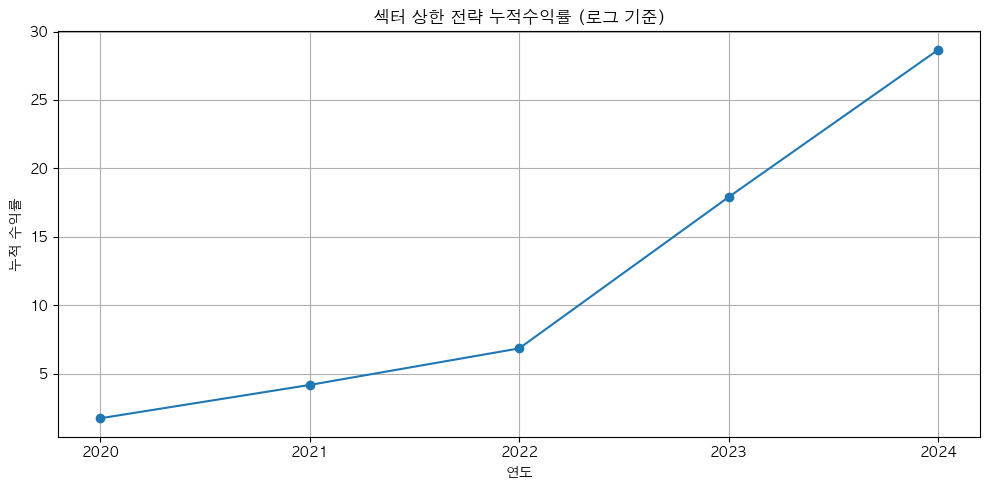

연도별 Top30 종목 리스트 저장 완료: 섹터상한_연도별_Top30_종목리스트.xlsx


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 파일 경로
file_path = '/Users/gun/Desktop/경종설/ML_dataset/2020_2024_데이터셋_WICS포함.xlsx'
df = pd.read_excel(file_path, dtype={'종목코드': str})

# 전처리
df['target'] = df['수익률_3개월'].clip(lower=-1, upper=1.6)
df['평균거래량증가율_rank'] = df['평균거래량증가율'].rank(pct=True)
df['시가총액_rank'] = df['시가총액'].rank(pct=True)
feature_columns = [col for col in df.columns if col.endswith('_rank') and col not in ['평균거래량증가율_rank', '시가총액_rank']]

vol_th = 0.9
cap_th = 0.6
sector_limit = 8

results = []
top30_all_years = []

for year in sorted(df['연도'].unique()):
    df_year = df[df['연도'] == year].dropna(subset=feature_columns + ['target', '산업군', '기업명'])
    if len(df_year) < 50:
        continue

    X = df_year[feature_columns]
    y = df_year['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    df_year['예측수익률'] = model.predict(X)
    filtered_df = df_year[
        (df_year['평균거래량증가율_rank'] <= vol_th) &
        (df_year['시가총액_rank'] <= cap_th)
    ].copy()

    filtered_df = filtered_df.sort_values(by='예측수익률', ascending=False)

    selected = []
    sector_counts = {}

    for _, row in filtered_df.iterrows():
        sector = row['산업군']
        if sector_counts.get(sector, 0) < sector_limit:
            selected.append(row)
            sector_counts[sector] = sector_counts.get(sector, 0) + 1
        if len(selected) >= 30:
            break

    selected_df = pd.DataFrame(selected)
    if len(selected_df) < 5:
        continue

    selected_df['연도'] = year
    top30_all_years.append(selected_df[['연도', '종목코드', '기업명', '산업군', '예측수익률', '수익률_3개월']])

    avg_return = selected_df['수익률_3개월'].mean()
    std_return = selected_df['수익률_3개월'].std()
    sharpe = avg_return / std_return if std_return > 0 else None
    log_return = np.log(1 + avg_return)

    results.append({
        '연도': year,
        'Top30 평균수익률 (섹터상한)': avg_return,
        'Sharpe (섹터상한)': sharpe,
        '로그수익률': log_return
    })

# 누적 수익률 계산 및 시각화
df_result = pd.DataFrame(results)
df_result['누적수익률_로그기준 (섹터상한)'] = np.exp(df_result['로그수익률'].cumsum())

plt.figure(figsize=(10, 5))
df_result.set_index('연도')['누적수익률_로그기준 (섹터상한)'].plot(marker='o')
plt.title('섹터 상한 전략 누적수익률 (로그 기준)')
plt.ylabel('누적 수익률')
plt.grid(True)
plt.xticks(df_result['연도'])
plt.tight_layout()
plt.show()

# 전체 종목 리스트 저장
df_top30_all = pd.concat(top30_all_years, ignore_index=True)
df_top30_all.to_excel('/Users/gun/Desktop/경종설/섹터상한_연도별_Top30_종목리스트.xlsx', index=False)
print("연도별 Top30 종목 리스트 저장 완료: 섹터상한_연도별_Top30_종목리스트.xlsx")

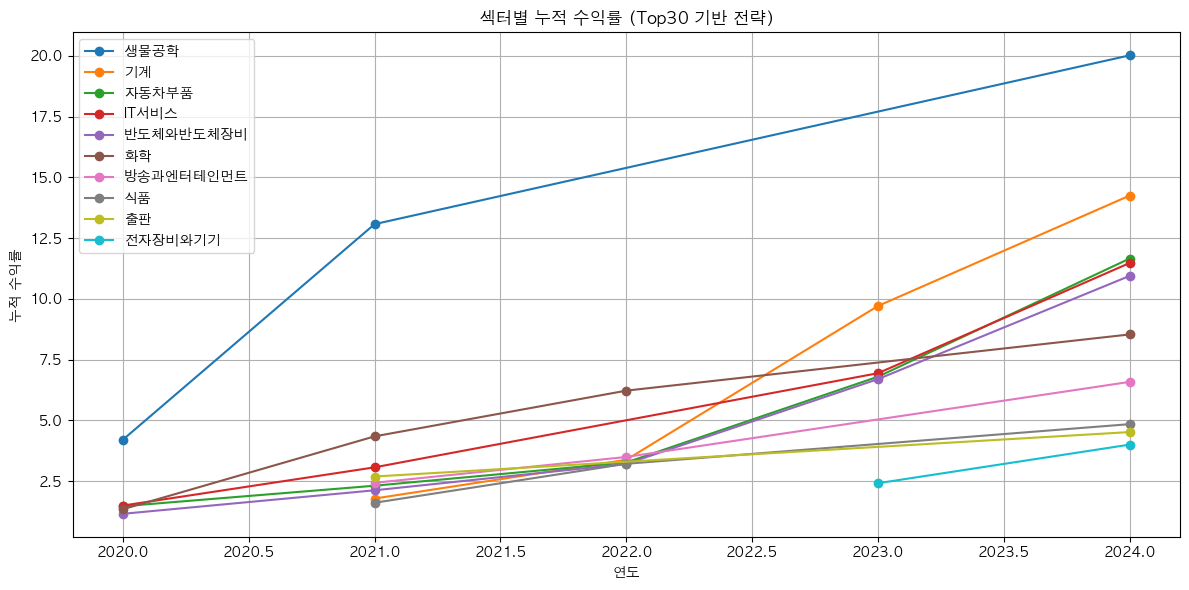

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ✅ Top30 종목 리스트 파일 (섹터 상한 전략 기반)
file_path = '/Users/gun/Desktop/경종설/섹터상한_연도별_Top30_종목리스트.xlsx'
df = pd.read_excel(file_path, dtype={'종목코드': str})

# ✅ 섹터별 연도별 평균 수익률 계산
sector_yearly = df.groupby(['산업군', '연도'])['수익률_3개월'].mean().reset_index()

# ✅ 누적 로그 수익률 계산
sector_yearly['로그수익률'] = np.log(1 + sector_yearly['수익률_3개월'])
sector_yearly['누적로그수익률'] = sector_yearly.groupby('산업군')['로그수익률'].cumsum()
sector_yearly['누적수익률'] = np.exp(sector_yearly['누적로그수익률'])

# ✅ 누적수익률이 가장 높은 상위 10개 산업군 선정 (마지막 연도 기준)
latest_year = sector_yearly['연도'].max()
top_sectors = sector_yearly[sector_yearly['연도'] == latest_year].sort_values(
    by='누적수익률', ascending=False)['산업군'].head(10).tolist()

# ✅ 시각화
plt.figure(figsize=(12, 6))
for sector in top_sectors:
    temp = sector_yearly[sector_yearly['산업군'] == sector]
    plt.plot(temp['연도'], temp['누적수익률'], marker='o', label=sector)

plt.title('섹터별 누적 수익률 (Top30 기반 전략)')
plt.xlabel('연도')
plt.ylabel('누적 수익률')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


📊 산업군별 평균 Sharpe 상위 10개
             산업군    Sharpe
51            화학  9.640370
32         자동차부품  7.620827
36       전자장비와기기  5.114460
23  섬유,의류,신발,호화품  4.848054
0          IT서비스  4.242041
7      건강관리장비와용품  3.488131
43            철강  3.172870
46          통신장비  3.154599
34          전기제품  3.134182
6     건강관리업체및서비스  3.115771

📊 산업군별 수익률 대비 편입 효율 상위 10개
           산업군  수익률_대비_편입효율
10    게임엔터테인먼트     5.691275
17         부동산     1.935103
48   항공화물운송과물류     1.866266
30          음료     1.588529
29          은행     1.292683
35        전문소매     1.072464
45    컴퓨터와주변기기     1.040863
3     가정용기기와용품     0.901408
22       석유와가스     0.854651
31  인터넷과카탈로그소매     0.816678

📊 산업군별 Sharpe 대비 편입 효율 상위 10개
             산업군  Sharpe_대비_편입효율
51            화학        1.606728
34          전기제품        1.567091
6     건강관리업체및서비스        1.557886
36       전자장비와기기        1.278615
32         자동차부품        1.270138
23  섬유,의류,신발,호화품        0.808009
8             건설        0.762573
43            철강        0.634574
46          통신

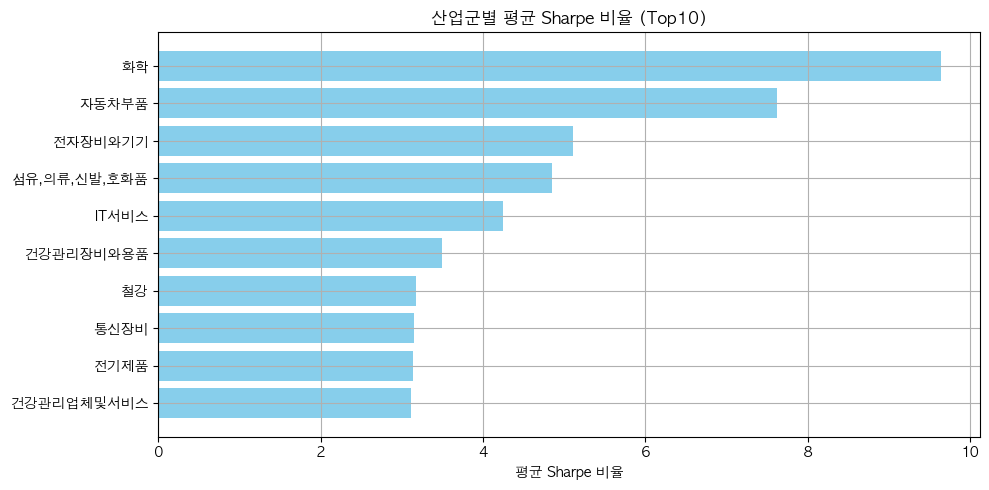

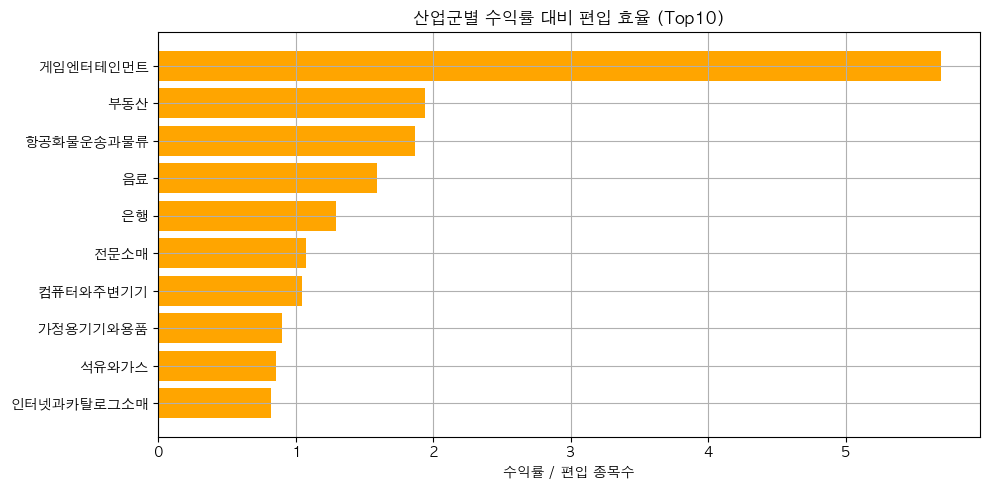

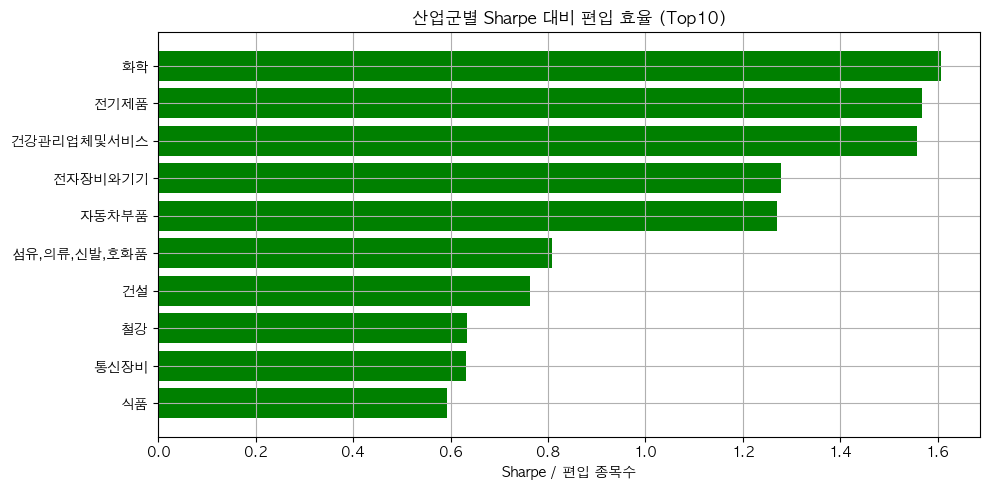

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ✅ 파일 경로
file_path = '/Users/gun/Desktop/경종설/섹터상한_연도별_Top30_종목리스트.xlsx'
df = pd.read_excel(file_path, dtype={'종목코드': str})

# ✅ 1. 연도별 Sharpe 계산
sector_group = df.groupby(['산업군', '연도'])
sharpe_df = sector_group['수익률_3개월'].agg(['mean', 'std', 'count']).reset_index()
sharpe_df['Sharpe'] = sharpe_df['mean'] / sharpe_df['std']
sharpe_df = sharpe_df.rename(columns={'mean': '평균수익률', 'std': '표준편차', 'count': '편입종목수'})

# ✅ 2. 산업군별 평균/효율 정리
efficiency = sharpe_df.groupby('산업군').agg({
    '평균수익률': 'mean',
    'Sharpe': 'mean',
    '편입종목수': 'sum'
}).reset_index()

efficiency['수익률_대비_편입효율'] = efficiency['평균수익률'] / efficiency['편입종목수']
efficiency['Sharpe_대비_편입효율'] = efficiency['Sharpe'] / efficiency['편입종목수']

# ✅ 3. 시각화 저장
plt.figure(figsize=(10, 5))
top_sharpe = efficiency.sort_values(by='Sharpe', ascending=False).head(10)
plt.barh(top_sharpe['산업군'], top_sharpe['Sharpe'], color='skyblue')
plt.xlabel('평균 Sharpe 비율')
plt.title('산업군별 평균 Sharpe 비율 (Top10)')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/gun/Desktop/경종설/시각화_Sharpe_Top10.png')

plt.figure(figsize=(10, 5))
top_eff_return = efficiency.sort_values(by='수익률_대비_편입효율', ascending=False).head(10)
plt.barh(top_eff_return['산업군'], top_eff_return['수익률_대비_편입효율'], color='orange')
plt.xlabel('수익률 / 편입 종목수')
plt.title('산업군별 수익률 대비 편입 효율 (Top10)')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/gun/Desktop/경종설/시각화_수익률편입효율_Top10.png')

plt.figure(figsize=(10, 5))
top_eff_sharpe = efficiency.sort_values(by='Sharpe_대비_편입효율', ascending=False).head(10)
plt.barh(top_eff_sharpe['산업군'], top_eff_sharpe['Sharpe_대비_편입효율'], color='green')
plt.xlabel('Sharpe / 편입 종목수')
plt.title('산업군별 Sharpe 대비 편입 효율 (Top10)')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/gun/Desktop/경종설/시각화_Sharpe편입효율_Top10.png')

# ✅ 4. 엑셀 저장
save_path = '/Users/gun/Desktop/경종설/섹터별_Sharpe_및_편입효율_분석결과.xlsx'
efficiency.to_excel(save_path, index=False)

# ✅ 5. 콘솔 요약 출력
print("\n📊 산업군별 평균 Sharpe 상위 10개")
print(top_sharpe[['산업군', 'Sharpe']])

print("\n📊 산업군별 수익률 대비 편입 효율 상위 10개")
print(top_eff_return[['산업군', '수익률_대비_편입효율']])

print("\n📊 산업군별 Sharpe 대비 편입 효율 상위 10개")
print(top_eff_sharpe[['산업군', 'Sharpe_대비_편입효율']])

print(f"\n✅ 분석 완료 및 저장:\n- 엑셀: {save_path}\n- 그래프 3종 이미지 저장 완료")